# Gas Predict

Predict gas fees for the next X hours to be able to judge how likely certain lows are going to happen.

We're especially interested in predicting the next low gas fees as well as their probabilities.

To download the data, we use `run-download.sh`.

### Read Data

In [25]:
import json

data_file = "data/data.json"

with open(data_file,"r") as f:
    data_json = json.load(f)

oN = len(data_json)
print(oN,"blocks")

392090 blocks


In [26]:
import numpy as np

In [28]:
# Convert to a format where we have an array with fields:
# blocknr, day in week, hour in day, minute in hour, second in minute

# Essentially, given a few days of gas prices, we want to predict how it's going to continue.

M = 7
# fields: blockr, gas, timestamp, median over window, minimum over window, 15%-quantile over window, 15%-quantile over past window
# each block will be centered in its window and not preceding it. this is, because we want all these
# rolling averages to have the spikes etc. on the same block
window_size = 30*60//12 # x minutes = x*60 seconds = x*60/12 blocks
odata = np.zeros((oN, M),dtype=np.int64)

i = 0
for k, v in data_json.items():
    fee = v["fee"]
    odata[i] = np.array([k,int(fee), v["t"], fee, fee, fee, fee],dtype=np.int64)
    i = i + 1
    
# sort by time (newest last)
odata = odata[odata[:,0].argsort()]

print("Calculating rolling windows...")
for i in range(oN):
    if i < window_size:
        continue
    m = i - window_size + window_size // 2
    odata[m,3] = np.median(odata[(i-window_size):i,1])
    odata[m,4] = np.min(odata[(i-window_size):i,1])
    odata[m,5] = np.quantile(odata[(i-window_size):i,1], 0.15)
    
    # live computable quantile
    odata[i,6] = np.quantile(odata[(i-window_size):i,1], 0.15)
    
print("Done.")
    
print(odata[:12])
print(odata[(oN-12):])

Calculating rolling windows...
Done.
[[  16607732         14 1676145191         14         14         14
          14]
 [  16607733         14 1676145203         14         14         14
          14]
 [  16607734         13 1676145215         13         13         13
          13]
 [  16607735         12 1676145227         12         12         12
          12]
 [  16607736         14 1676145239         14         14         14
          14]
 [  16607737         16 1676145251         16         16         16
          16]
 [  16607738         18 1676145263         18         18         18
          18]
 [  16607739         17 1676145275         17         17         17
          17]
 [  16607740         19 1676145287         19         19         19
          19]
 [  16607741         18 1676145299         18         18         18
          18]
 [  16607742         18 1676145311         18         18         18
          18]
 [  16607743         18 1676145323         18         18     

Rather than predicting the gas price, it makes more sense to create moving median, minimum and x quantile (e.g. 15%%) and predict that.
Otherwise the high spikes in gas price will dominate the predictions even though we're rather interested in the lows.

---

## Gas Price with moving median/minimun/quantile(15%)

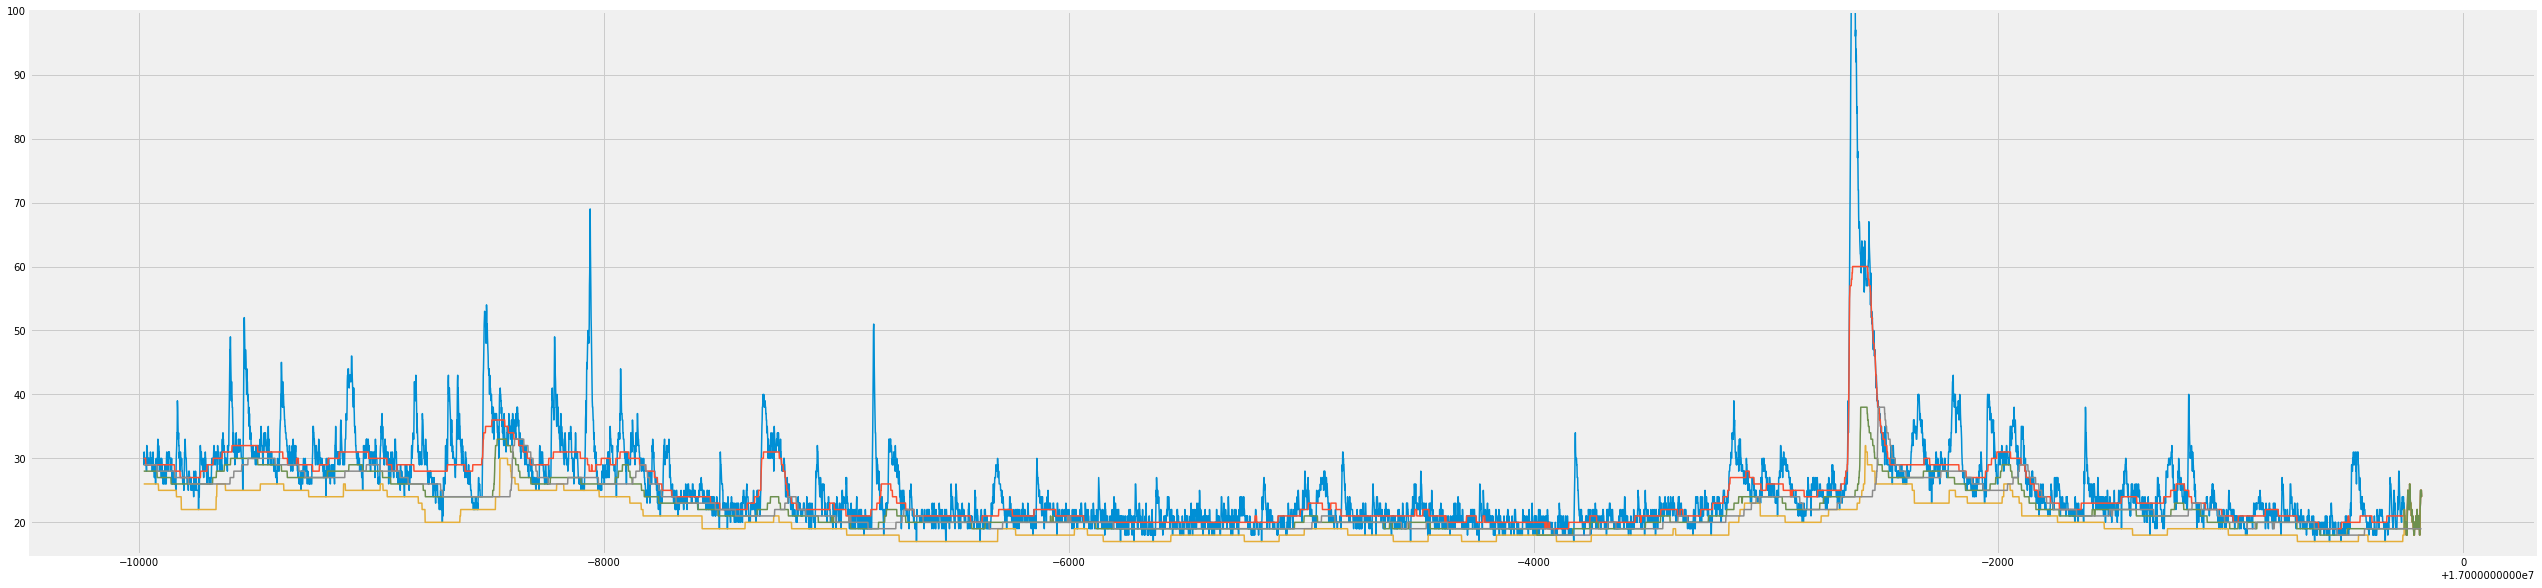

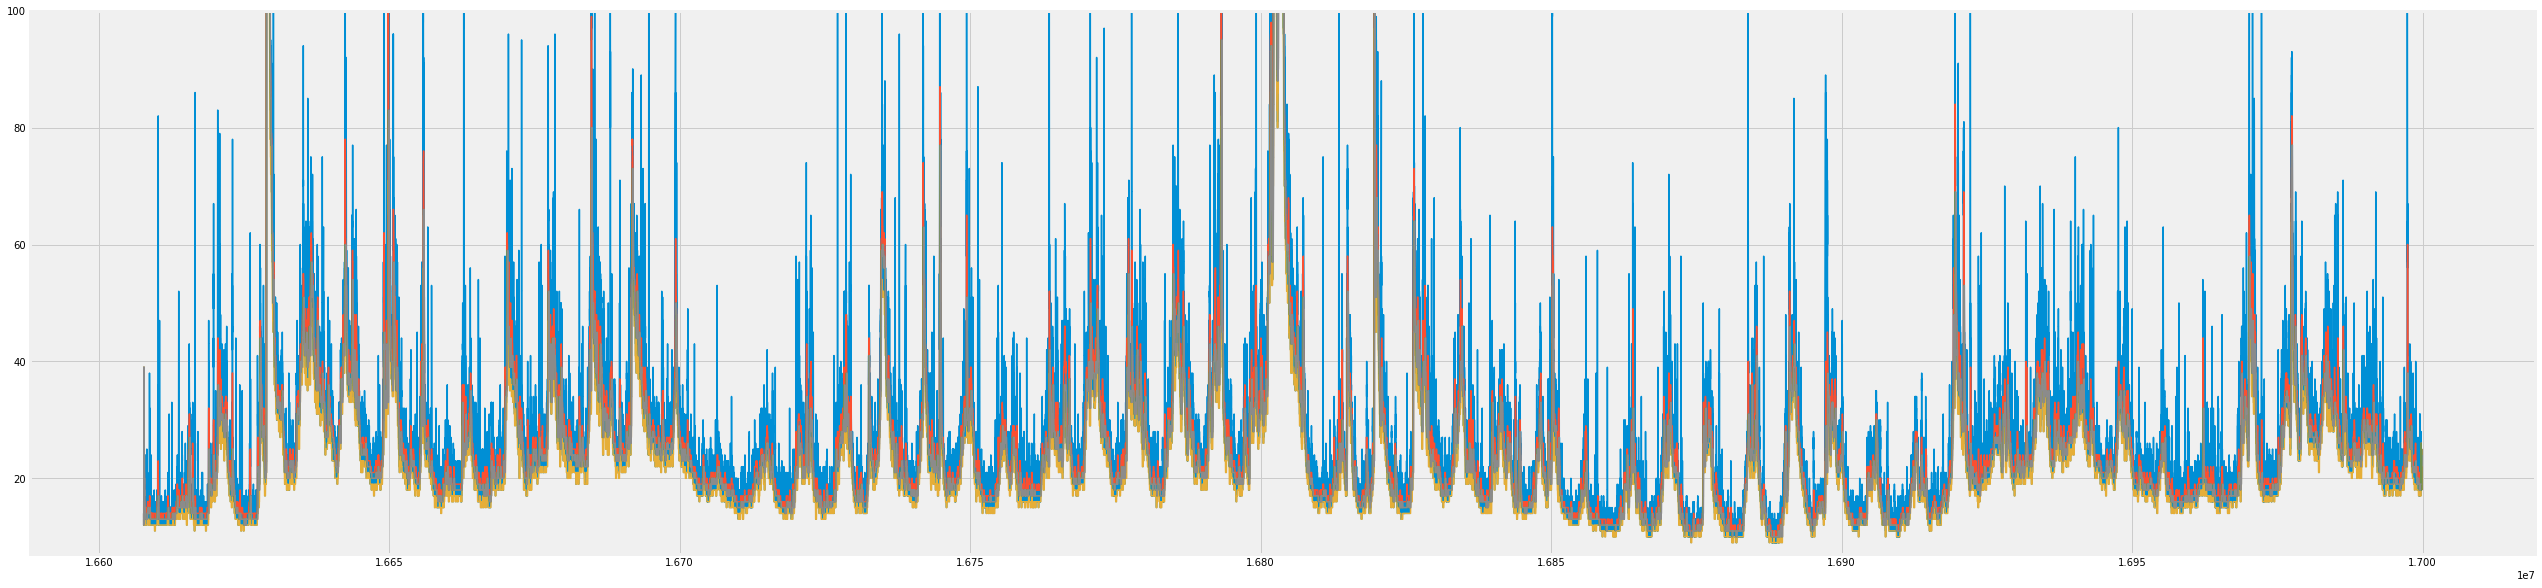

In [36]:
import matplotlib.pyplot as plt

showN = oN // 40

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.plot(odata[-showN:,0],odata[-showN:,6])
plt.ylim(15,100)
plt.show()

showN = oN

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.plot(odata[-showN:,0],odata[-showN:,6])
plt.ylim(7,100)
plt.show()


## Forcasting

Used this tutorial/template:
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

PYAF: https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b


In [51]:
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# ================================
import pyaf.ForecastEngine as autof

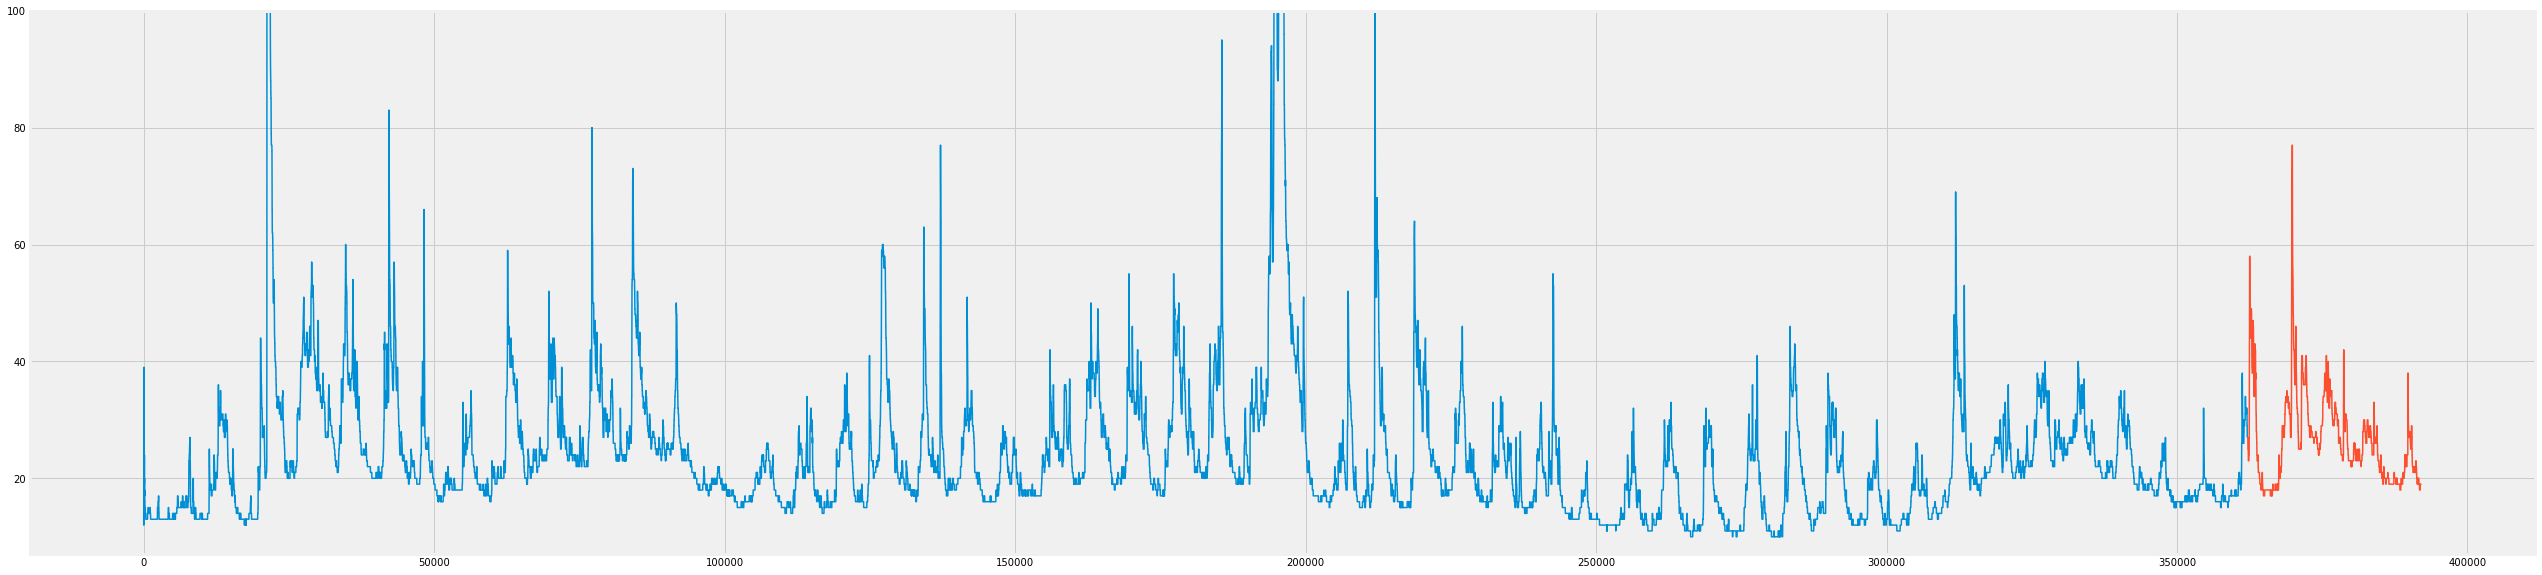

In [72]:
# test train split

nBlockTest = 30000
skip = 0 # 100000
oNt = oN - skip

data_train = pd.DataFrame(odata[skip:-nBlockTest, [0,5,6]]) # keep only mid-window-quantile and live-quantile
data_test  = pd.DataFrame(odata[-nBlockTest:, [0,5,6]])
cols = ["BlockNr","Quantile","Live-Quantile"] # , "Median", "Minimum"
xVar = "Live-Quantile"
yVar = "Quantile"
data_train.columns = cols
data_test.columns = cols

                          
plt.figure(figsize=(40,10))
plt.plot(np.arange(oNt-nBlockTest),data_train[xVar])
plt.plot(np.arange(nBlockTest)+(oNt-nBlockTest),data_test[xVar])
plt.ylim(7,100)
plt.show()

In [73]:
models = ["firecasterautoreg", "pyaf"]

model = models[1]

pred_past_window = 9000

if model == models[0]:

    forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=1337),
        lags=pred_past_window
    )

    forecaster.fit(y=data_train[yVar])
    print(forecaster)
elif model == models[1]:
    lEngine = autof.cForecastEngine()# get the best time series model for test prediction
    lEngine.train(iInputDS = data_train, iTime = "BlockNr", iSignal = yVar, iHorizon = pred_past_window)
else:
    raise ValueError

pyaf.timing INFO  ('OPERATION_START', ('SIGNAL_TRAINING', {'Signals': ['Quantile'], 'Transformations': [('Quantile', 'None', '_', 'T+S+R'), ('Quantile', 'None', 'Diff_', 'T+S+R'), ('Quantile', 'None', 'RelDiff_', 'T+S+R'), ('Quantile', 'None', 'CumSum_', 'T+S+R')], 'Cores': 4}))
pyaf.timing INFO  ('OPERATION_START', ('TRAINING', {'Signal': 'Quantile', 'Transformation': '_Quantile'}))
/home/swaneet/.local/lib/python3.10/site-packages/pyaf/TS/Time.py:133: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  lDiffs = lEstim[self.mTime][1:N] - lTimeBefore[1:N]
pyaf.timing INFO  ('OPERATION_START', ('TRAINING', {'Signal': 'Quantile', 'Transformation': 'Diff_Quantile'}))
/home/swaneet/.local/lib/python3.10/site-packages/pyaf/TS/Time.py:133: Futu

In [74]:
steps = 10000
if model == models[0]:
    predictions = forecaster.predict(steps=steps)
elif model == models[1]:
    predictions = lEngine.forecast(data_test,steps)
    
predictions.head(5)

pyaf.timing INFO  ('OPERATION_START', ('FORECASTING', {'Signals': ['Quantile'], 'Horizon': 10000}))
pyaf.timing INFO  ('OPERATION_END_ELAPSED', 114.346, ('FORECASTING', {'Signals': ['Quantile'], 'Horizon': 10000}))


,BlockNr,Quantile,row_number,BlockNr_Normalized,_Quantile,_Quantile_Lag1Trend,_Quantile_Lag1Trend_residue,_Quantile_Lag1Trend_residue_zeroCycle[0.0],_Quantile_Lag1Trend_residue_zeroCycle[0.0]_residue,_Quantile_Lag1Trend_residue_zeroCycle[0.0]_residue_NoAR,...,Quantile_Forecast_Quantile_50,Quantile_Forecast_Quantile_55,Quantile_Forecast_Quantile_60,Quantile_Forecast_Quantile_65,Quantile_Forecast_Quantile_70,Quantile_Forecast_Quantile_75,Quantile_Forecast_Quantile_80,Quantile_Forecast_Quantile_85,Quantile_Forecast_Quantile_90,Quantile_Forecast_Quantile_95
0,16991630,29.0,0,3.662556,0.608696,0.173913,0.434783,0.0,0.434783,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16991631,29.0,1,3.662679,0.608696,0.608696,0.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16991632,29.0,2,3.662801,0.608696,0.608696,0.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16991633,28.0,3,3.662923,0.565217,0.608696,-0.043478,0.0,-0.043478,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16991634,28.0,4,3.663045,0.565217,0.565217,0.000000,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
predictions.info()
# why does this have such a weird length?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18192 entries, 0 to 18191
Data columns (total 42 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   BlockNr                                                          18192 non-null  int64  
 1   Quantile                                                         8192 non-null   float64
 2   row_number                                                       18192 non-null  int64  
 3   BlockNr_Normalized                                               18192 non-null  float64
 4   _Quantile                                                        8192 non-null   float64
 5   _Quantile_Lag1Trend                                              18192 non-null  float64
 6   _Quantile_Lag1Trend_residue                                      8192 non-null   float64
 7   _Quantile_Lag1Trend_residue_zeroCycle[0.

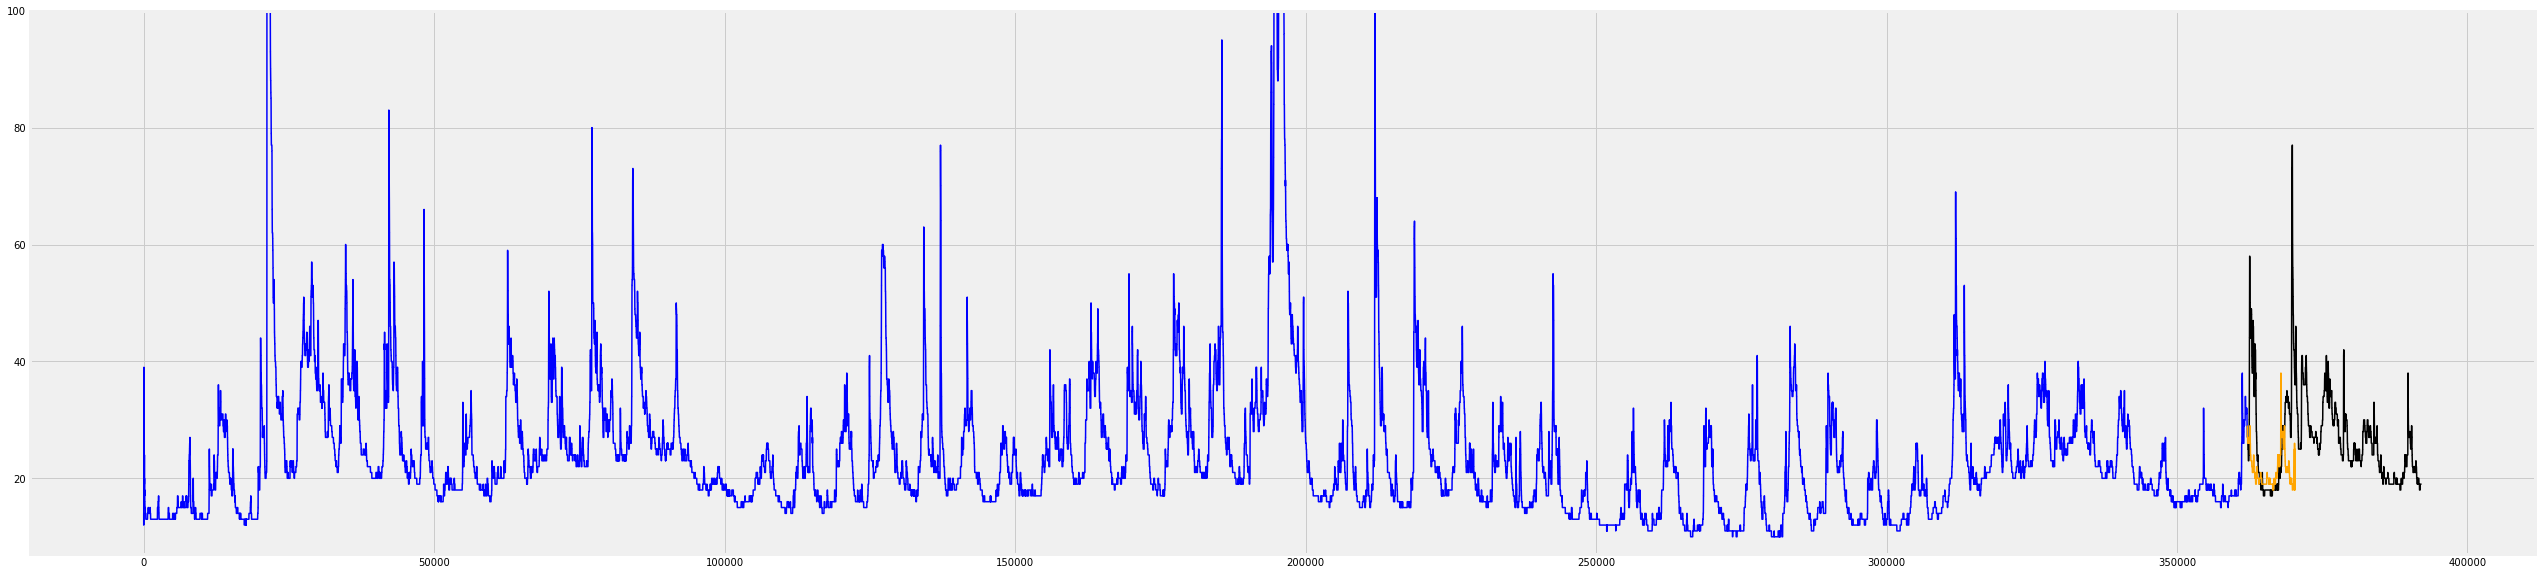

In [76]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(oNt-nBlockTest),data_train[xVar],"b")
plt.plot(np.arange(nBlockTest)+(oNt-nBlockTest),data_test[xVar],"black")#
plt.plot(np.arange(len(predictions))+(oNt-nBlockTest),predictions if model == models[0] else predictions[yVar],"orange")
plt.ylim(7,100)
plt.show()